In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import glob
import cPickle as cp
import hera_cal
import aipy
import scipy
from astropy.time import Time
import astropy
import astropy.units as u

In [2]:
files = glob.glob('hera_idr2p1_gains/245*')
INT_TIME = 10.73741912841797

files.sort()

with open(files[1],'r') as fp:
    data = cp.load(fp)

/home/deepthi/anaconda3/envs/py27/lib/python2.7/site-packages/astropy/time/core.py:750: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif longitude == 'greenwich':


<IPython.core.display.Javascript object>


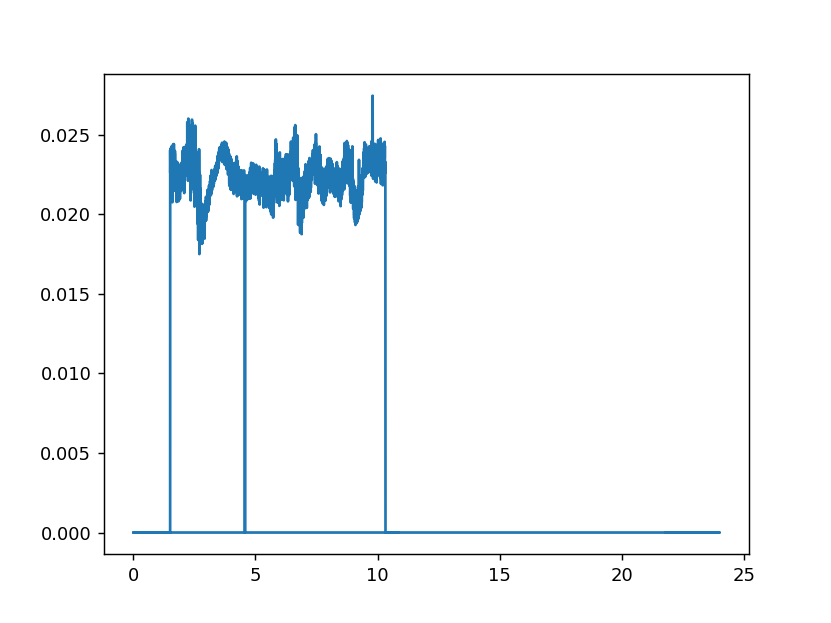

In [3]:
dflags = np.concatenate(data['flags'])
dgains = np.concatenate(data['gains'])

dwgts = np.logical_not(dflags)
dgains = dgains*dwgts

dtime = Time(np.concatenate(data['times']),format='jd') #np.arange(np.size(dgains))*INT_TIME
longitude = astropy.coordinates.Longitude(21.5,unit=u.deg)
lst = dtime.sidereal_time('mean',longitude=21.5*u.deg)

plt.figure()
plt.plot(lst.hour,np.abs(dgains))

<IPython.core.display.Javascript object>


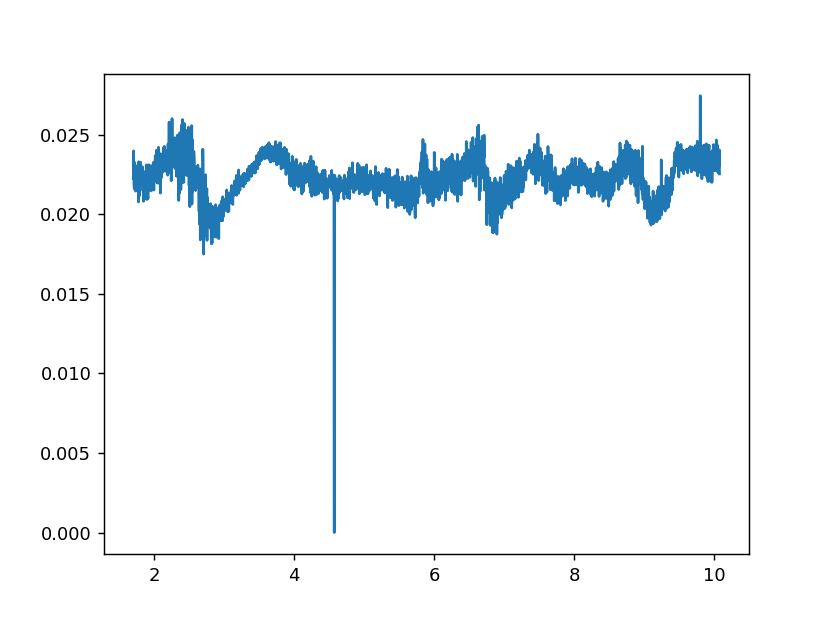

In [4]:
# Cut out flagged areas
dgains = dgains[1300:4100]
dwgts = dwgts[1300:4100]
dtime = dtime[1300:4100]
lst = dtime.sidereal_time('mean',longitude=21.5*u.deg)

plt.figure()
plt.plot(lst.hour, np.abs(dgains))

In [5]:
# Deconvolve to interpolate the single flagged value

Fdg = np.fft.ifft(dgains)
Fdker = np.fft.ifft(dwgts)

fringe_rate = np.fft.fftfreq(np.size(dtime),d=INT_TIME)

Fdg_deconv = aipy.deconv.clean(im = Fdg, ker = Fdker, tol=1e-6)

<IPython.core.display.Javascript object>


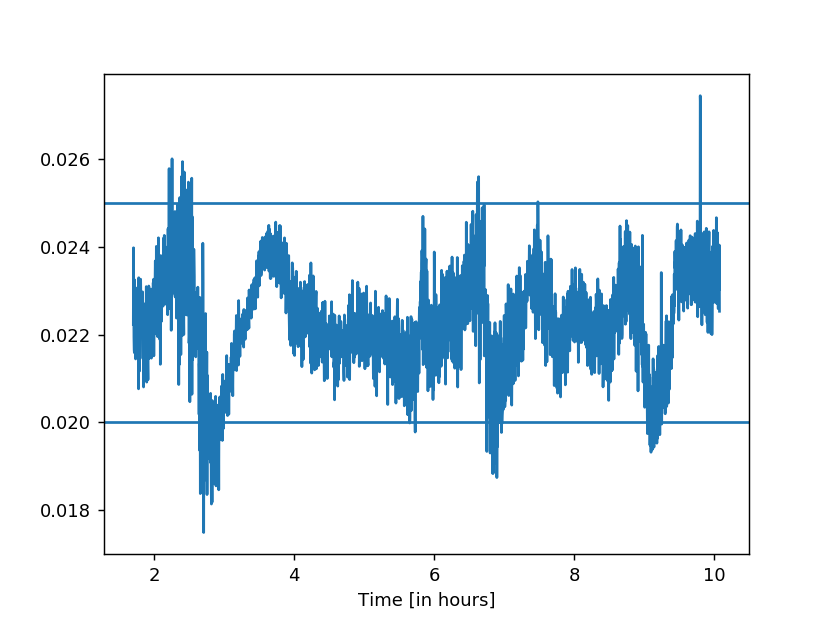

In [6]:
# Interpolated and cleaned gains for a single day
gains_day = np.abs(np.fft.fft(Fdg_deconv[0] + Fdg_deconv[1]['res']))

# Check that the fourier transform converged
plt.figure()
plt.plot(lst.hour,gains_day)
#plt.plot(time_range/(60*60),np.abs(dgains),'--r',alpha=0.5)
plt.xlabel('Time [in hours]')
plt.axhline(y=0.025)
plt.axhline(y=0.02)

In [68]:
print(1103-769)
print len(lst.hour)

334
2800


<IPython.core.display.Javascript object>


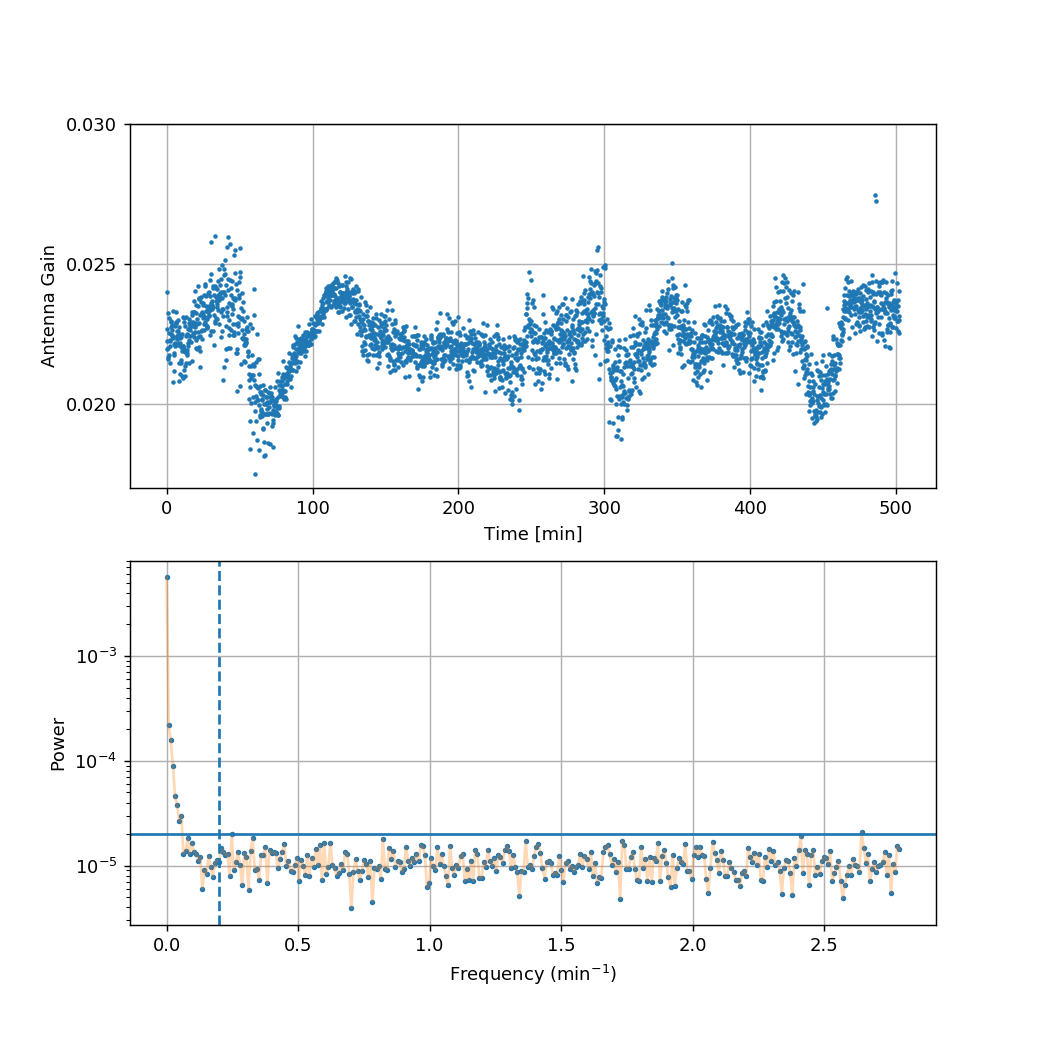

In [12]:
#r1 = 769; r2 = 1103 # 1hr
r1 = 0; r2 = 2800   # all time
#r1 = 700; r2 = 1370 # 2hr
h = (r2-r1)//2

fig, ax = plt.subplots(2,1,figsize=(8,8))
t = (lst.hour[r1:r2]-lst.hour[r1])*60
ax[0].plot(t,gains_day[r1:r2],'.',markersize=3)
#ax[0].plot(lst.hour[r1:r2],gains_day[r1:r2],alpha=0.3)
#ax[0].set_ylim([0.015,0.035])
#ax[0].set_xlim([0,120])
ax[0].set_yticks([0.02,0.025,0.03])
ax[0].set_xlabel('Time [min]')
ax[0].set_ylabel('Antenna Gain')
ax[0].grid()

fvar = np.fft.fftfreq(r2-r1, d=INT_TIME)*60
gvar_fft = np.fft.ifft(gains_day[r1:r2])

# ax[1].semilogy(fvar[:h], np.abs(gvar_fft)[:h],'o', markersize=2)
# ax[1].semilogy(fvar[:h], np.abs(gvar_fft)[:h],'-', alpha=0.3)

# # What if I decrease time resolution
# fvar = np.fft.fftfreq((r2-r1)/2, d=2*INT_TIME)*60
# gvar_fft = np.fft.ifft(np.mean(gains_day[r1:r2].reshape(-1,2),axis=1))
# ax[1].semilogy(fvar, np.abs(gvar_fft),'o', markersize=2)
# ax[1].semilogy(fvar, np.abs(gvar_fft),'-', alpha=0.3)

# Decrease the resolution of the fourier transform
# You need a resolution of 120min of data
f = fvar[:h:4]
gf = np.mean((np.abs(gvar_fft[:h])).reshape(-1,4), axis=1)
ax[1].semilogy(f, gf, 'o', markersize=2)
ax[1].semilogy(f, gf, '-', alpha=0.3)

ax[1].set_xlabel(r'Frequency (min$^{-1}$)')
ax[1].set_ylabel('Power')
ax[1].axhline(y=2e-5)
ax[1].axvline(x=0.2,ls='--')
#ax[1].set_xlim([0,1.4])
#ax[1].axvline(x=0.033182,label='30 s')
#ax[1].axvline(x=-0.033182,label='30 s')
ax[1].grid()

In [96]:
# nu = fvar[:h]
# gvar_fft_data = np.abs(gvar_fft)[:h]

# gvar_fft_model = (nu[1:]/3e-5)**-1 + (nu[1:]/4.8e-20)**-0.2

# plt.figure()
# plt.semilogy(nu, gvar_fft_data, '.')
# plt.semilogy(nu, gvar_fft_data, '-',alpha=0.3)
# plt.semilogy(nu[1:], gvar_fft_model,'-')

<IPython.core.display.Javascript object>


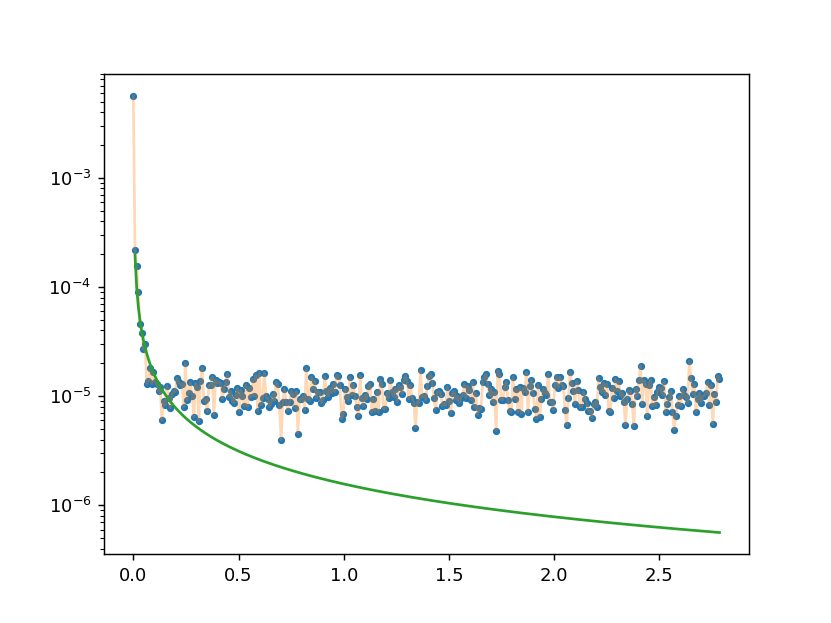

In [51]:
f = fvar[:h:4]
gf = np.mean((np.abs(gvar_fft[:h])).reshape(-1,4), axis=1)
gm = 1.57e-6*(f[1:])**-1 #+ 5e-3*(f[1:])**-0.2

# 2e-11      -4
# 1.57e-6    -1

plt.figure()
plt.semilogy(f, gf, '.')
plt.semilogy(f, gf, '-',alpha=0.3)
plt.semilogy(f[1:], gm,'-')
#plt.xlim([-0.03,0.3])
#plt.ylim([1e-5,1e-2])

<IPython.core.display.Javascript object>


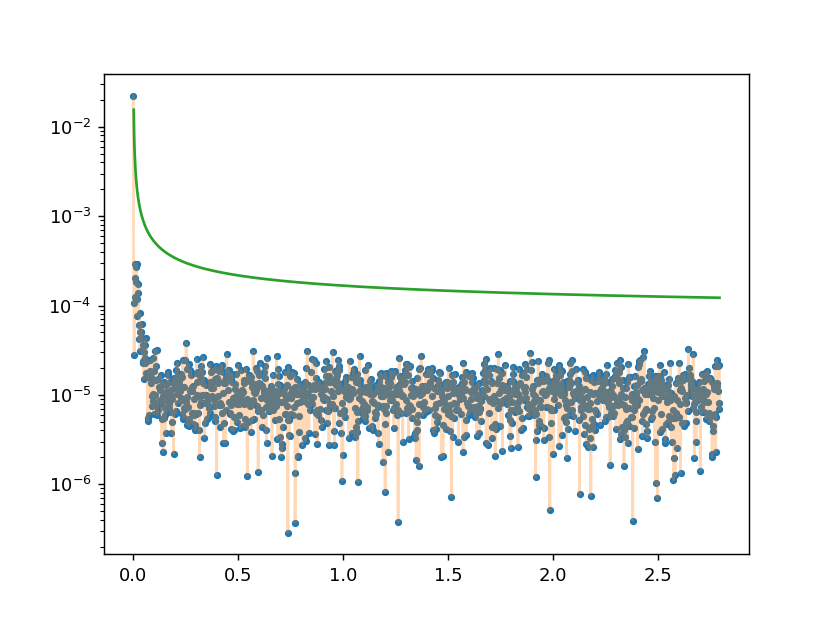

In [8]:
w = scipy.signal.wiener(np.abs(gvar_fft))

/home/deepthi/anaconda3/envs/py27/lib/python2.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


<IPython.core.display.Javascript object>


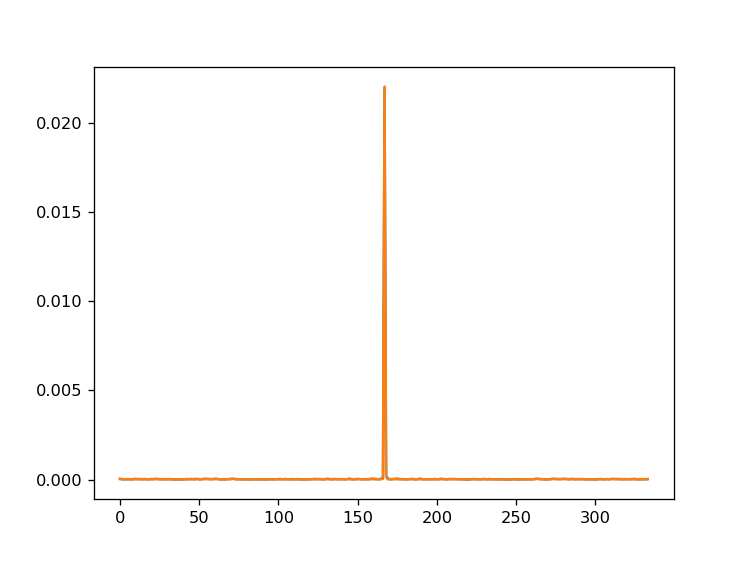

In [9]:
plt.figure()
plt.plot(np.fft.fftshift(np.abs(w)))
plt.plot(np.fft.fftshift(np.abs(gvar_fft)))